In [36]:

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision import transforms, utils
import torchvision
import warnings
warnings.filterwarnings("ignore")
plt.ion() 


In [37]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [38]:
# Hyper-parameters
h_dim = 400
z_dim = 20
num_epochs = 15
batch_size = 4
learning_rate = 1e-3
nrow, ncol= 56, 56
image_size = nrow*ncol

In [39]:
data_transform = transforms.Compose([
        transforms.Resize(size=[nrow, ncol]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])])

data_dir = 'data'
# Data sets
dataset  =  datasets.ImageFolder(root=data_dir,transform = data_transform)
# Data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size = 4,
                                             shuffle = True, num_workers = 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0,  0,  1,  0])
tensor(0) tensor(0) tensor(1) tensor(0)


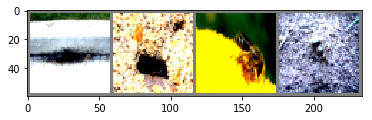

In [40]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(labels)
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))    

In [41]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=image_size, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


In [42]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [43]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)        
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, nrow, ncol)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, nrow, ncol), out.view(-1, 1,nrow, ncol)], dim=3)
save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

Epoch[1/15], Step [10/39], Reconst Loss: -77386.9766, KL Div: 11155.0254
Epoch[1/15], Step [20/39], Reconst Loss: -323253.1250, KL Div: 20035.3711
Epoch[1/15], Step [30/39], Reconst Loss: -74710.2031, KL Div: 5620.9756
Epoch[2/15], Step [10/39], Reconst Loss: -300019.8438, KL Div: 19078.7656
Epoch[2/15], Step [20/39], Reconst Loss: -31109.0254, KL Div: 1890.5359
Epoch[2/15], Step [30/39], Reconst Loss: -167284.6406, KL Div: 9537.0215
Epoch[3/15], Step [10/39], Reconst Loss: -201411.9062, KL Div: 9018.2949
Epoch[3/15], Step [20/39], Reconst Loss: -222272.4062, KL Div: 21024.5488
Epoch[3/15], Step [30/39], Reconst Loss: -178059.7656, KL Div: 5304.1494
Epoch[4/15], Step [10/39], Reconst Loss: -173662.4844, KL Div: 8850.7119
Epoch[4/15], Step [20/39], Reconst Loss: -306951.9688, KL Div: 7244.8550
Epoch[4/15], Step [30/39], Reconst Loss: -164417.6250, KL Div: 2482.9839
Epoch[5/15], Step [10/39], Reconst Loss: -627748.6250, KL Div: 12177.5654
Epoch[5/15], Step [20/39], Reconst Loss: -291747.